In [5]:
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.utils
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import sklearn.model_selection
import importlib
import sys
%load_ext tensorboard

function_dir = os.path.join(os.pardir, 'Functions')
sys.path.append(function_dir)

import models as mod
importlib.reload(mod) #to make sure the last version of seg is used
import DLtools as tools


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The first thing to do is to create a dataset, by linking the images to the name of each algae:

In [6]:
#address of the base folder:
base = "R:\\3.Masters_projects\\2021_Dominic_Rebindaine\\ROI"
#extract the name from the file name:
name_l =[]
path_l = []
for fname in os.listdir(base):
    pathto = os.path.join(base,fname)
    
    if os.path.isdir(pathto):
        path_l.append(pathto)
        split = fname.split(sep='_')
        if len(split)>2:
            name = split[1]
            name_l.append(name)

In [7]:
#group identical labels together:
label_name, label = np.unique(name_l,return_inverse=True)

In [8]:
label_name

array(['Astrionella', 'Cryptomonas', 'Eudorina', 'Greifensee', 'Oocystis',
       'Staurastrum', 'Tetraedron', 'Volvox', 'planktothrix', 'pond2'],
      dtype='<U12')

In [9]:
#define the input data:
size = 200

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0690568], dtype=float32)>

In [47]:
#open the images and find their label
def data_opener(name):
    img = tf.io.decode_png(tf.io.read_file(name))
    X = tf.image.resize(img,(size,size))
    Xn = tf.image.per_image_standardization(X)
    part = tf.strings.split(name,os.sep)
    fname = part[4]
    fpart = tf.strings.split(fname,'_')
    if len(fpart)<2:
        y = -1
    else:
        el_label = fpart[1]
        y = -1
        for idx, label in enumerate(label_name):
            if label == el_label:
                y = idx
    data = (Xn,y)
    return data
def upsample(name_list, n_cat):
    n_sample = np.zeros(n_cat)
    for name in name_list:
        part = tf.strings.split(name,os.sep)
        fname = part[4]
        fpart = tf.strings.split(fname,'_')
        if len(fpart)<2:
            y = -1
        else:
            el_label = fpart[1]
            y = -1
            for idx, label in enumerate(label_name):
                if label == el_label:
                    y = idx
        data = (Xn,y)
#logs: aug:   no gaussian noise
#      aug2:  gaussian noise with stddev = 0.1
#      aug3:  gaussian noise with stddev in [0:0.2] (and no random sat or contrast)
#      aug4:  data shuffled each epoch
#      aug5:  gaussian noise removed
def data_aug(img,label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    rnd = np.random.randint(4)
    img = tf.image.rot90(img,k=rnd)
    img = tf.image.random_hue(img,0.1)
    #stddev = tf.random.uniform(shape=[1],maxval=0.05)
    #img+= tf.random.normal((size,size,3),stddev=stddev)
    return (img,label)


def input_pipeline(ds, augmentation = False):
    ds = ds.shuffle(10000)
    ds = ds.map(data_opener)
    #filter out the unlabeled elements
    ds = ds.filter(lambda X,y: y>=0)
    if augmentation:
        ds = ds.map(data_aug)
    ds = ds.batch(32)
    ds = ds.prefetch(3)
    return ds

    

In [48]:
file_names = tf.data.Dataset.list_files('R:\\3.Masters_projects\\2021_Dominic_Rebindaine\\ROI\\*\\*\\*.png')
#split the dataset now, as the loading of the image would need too long to use the list function
train, val = sklearn.model_selection.train_test_split(list(file_names),test_size= 0.2)
dt = tf.data.Dataset.from_tensor_slices(train)
dv = tf.data.Dataset.from_tensor_slices(val)

dt = input_pipeline(dt,augmentation = True)
dv = input_pipeline(dv)

In [22]:
#to allow an easy plot with matplotlib
def destand(img_n, perc = 1,epsilon = 0.0001):
    pl,ph = np.percentile(img_n, [perc,100-perc])
    img = np.array((img_n-pl)/(epsilon+ph-pl))
    img[img>1]=1
    img[img<0]=0
    return img

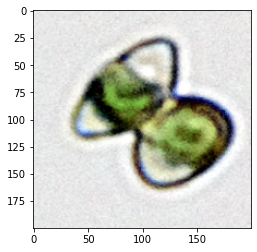

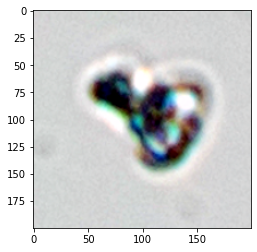

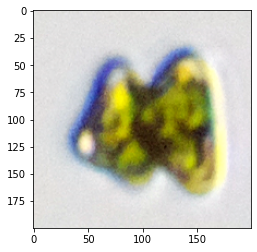

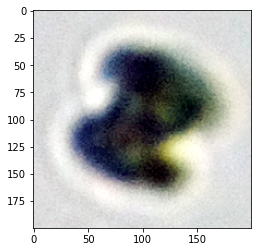

In [49]:
for i, (X,y) in enumerate(dt):
    plt.imshow(destand(X[1]))
    plt.show()
    if i > 0:
        break

for i, (X,y) in enumerate(dv):
    plt.imshow(destand(X[0]))
    plt.show()
    if i > 0:
        break

In [26]:
i = 0
label_t = np.array([])
label_v = np.array([])
for X,y in dv:
    label_v = np.append(label_v,y.numpy())
for X,y in dt:
    label_t = np.append(label_t,y.numpy())

KeyboardInterrupt: 

In [ ]:
histv,t = np.histogram(label_v)
histt,t = np.histogram(label_t)

In [ ]:
label_name

In [ ]:
x = np.arange(len(label_name))
width = 0.35
plt.bar(x+width/2,histv/np.sum(histv),width)
plt.bar(x-width/2,histt/np.sum(histt),width)
plt.xticks(x, label_name,rotation='vertical')
plt.legend(['validation set','training set'])
plt.show()

With these dataset created, one can start creating and training networks. They are written in the models.py file in the Function folder:

In [89]:
model_naive = mod.naive_conv(size = size, n_out = len(label_name))

In [90]:
model_naive.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 196, 196, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        1849

In [91]:
model_naive.compile(optimizer="Adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False))

In [29]:
savebest = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=7,
    restore_best_weights=True)
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8396), started 1 day, 1:42:47 ago. (Use '!kill 8396' to kill it.)

In [30]:
log_dir = 'logs/test_naive_aug2'
history = model_naive.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

NameError: name 'model_naive' is not defined

As the model quickly overfit, some dropout was added:

In [94]:
model_drop = mod.dropout_conv(size = size, n_out = len(label_name))
model_drop.summary()
model_drop.compile(optimizer="Adam",
                   loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 196, 196, 16)      2320      
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 196, 196, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 96, 96, 32)        0   

In [95]:
log_dir = 'logs/test_dropout_aug2'
history = model_drop.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/50
265/265 [==============================] - 240s 903ms/step - loss: 1.4542 - val_loss: 1.2638
Epoch 2/50
265/265 [==============================] - 176s 663ms/step - loss: 1.2201 - val_loss: 1.2319
Epoch 3/50
265/265 [==============================] - 203s 766ms/step - loss: 1.1469 - val_loss: 1.2495
Epoch 4/50
265/265 [==============================] - 156s 587ms/step - loss: 1.0978 - val_loss: 1.2150
Epoch 5/50
265/265 [==============================] - 141s 531ms/step - loss: 1.0273 - val_loss: 1.0792
Epoch 6/50
265/265 [==============================] - 199s 753ms/step - loss: 0.9820 - val_loss: 0.9250
Epoch 7/50
265/265 [==============================] - 164s 614ms/step - loss: 0.9378 - val_loss: 0.9652
Epoch 8/50
265/265 [==============================] - 151s 570ms/step - loss: 0.9044 - val_loss: 0.9585
Epoch 9/50
265/265 [==============================] - 164s 619ms/step - loss: 0.8824 - val_loss: 0.9309
Epoch 10/50
265/265 [==============================] - 172s 649m

In [50]:
#as the model seems to underfit, a less strict dropout was applied, with a few other differences:
#the network is a bit deeper, and the last convolution is globally pooled instead of flattened
importlib.reload(mod)
model_ldrop = mod.dropout_low_conv(size = size, n_out = len(label_name))
model_ldrop.summary()
model_ldrop.compile(optimizer = 'Adam',
                    loss =keras.losses.SparseCategoricalCrossentropy(from_logits = False))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 196, 196, 16)      2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 46, 46, 64)        1849

In [51]:
log_dir = 'logs/test_low_dropout_aug5'
history = model_ldrop.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/50
265/265 [==============================] - 165s 619ms/step - loss: 1.5519 - val_loss: 1.2200
Epoch 2/50
265/265 [==============================] - 172s 648ms/step - loss: 1.2386 - val_loss: 1.1416
Epoch 3/50
265/265 [==============================] - 167s 630ms/step - loss: 1.1555 - val_loss: 1.0419
Epoch 4/50
265/265 [==============================] - 162s 611ms/step - loss: 1.0679 - val_loss: 0.9861
Epoch 5/50
265/265 [==============================] - 159s 599ms/step - loss: 1.0085 - val_loss: 0.9683
Epoch 6/50
265/265 [==============================] - 162s 612ms/step - loss: 0.9747 - val_loss: 1.0664
Epoch 7/50
265/265 [==============================] - 155s 584ms/step - loss: 0.9301 - val_loss: 0.9145
Epoch 8/50
265/265 [==============================] - 162s 613ms/step - loss: 0.8933 - val_loss: 0.8762
Epoch 9/50
265/265 [==============================] - 182s 688ms/step - loss: 0.8645 - val_loss: 0.8434
Epoch 10/50
265/265 [==============================] - 182s 686m

In [38]:
#test another version, with more parameters:
importlib.reload(mod)
model_ldrop2 = mod.dropout_low_conv2(size = size, n_out = len(label_name))
model_ldrop2.summary()
model_ldrop2.compile(optimizer = 'Adam',
                    loss =keras.losses.SparseCategoricalCrossentropy(from_logits = False))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 196, 196, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 46, 46, 64)        1849

In [39]:
log_dir = 'logs/test_low_dropout2_true_aug4'
history = model_ldrop2.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/50
265/265 [==============================] - 147s 546ms/step - loss: 1.5209 - val_loss: 1.1978
Epoch 2/50
265/265 [==============================] - 127s 478ms/step - loss: 1.2388 - val_loss: 1.0748
Epoch 3/50
265/265 [==============================] - 139s 524ms/step - loss: 1.1563 - val_loss: 1.0304
Epoch 4/50
265/265 [==============================] - 140s 527ms/step - loss: 1.0947 - val_loss: 0.9587
Epoch 5/50
265/265 [==============================] - 141s 530ms/step - loss: 1.0420 - val_loss: 1.0931
Epoch 6/50
265/265 [==============================] - 131s 494ms/step - loss: 0.9893 - val_loss: 0.8917
Epoch 7/50
265/265 [==============================] - 123s 464ms/step - loss: 0.9604 - val_loss: 0.8549
Epoch 8/50
242/265 [==========================>...] - ETA: 8s - loss: 0.9039

KeyboardInterrupt: 

In [43]:
importlib.reload(mod)
model_ldrop4 = mod.dropout_low_conv4(size = size, n_out = len(label_name))
model_ldrop4.summary()
model_ldrop4.compile(optimizer = 'Adam',
                    loss =keras.losses.SparseCategoricalCrossentropy(from_logits = False))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 196, 196, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 46, 46, 64)        1849

In [46]:
log_dir = 'logs/test_low_dropout4_aug4'
history = model_ldrop4.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/50
265/265 [==============================] - 157s 593ms/step - loss: 1.5038 - val_loss: 1.2173
Epoch 2/50
265/265 [==============================] - 158s 596ms/step - loss: 1.2136 - val_loss: 1.0323
Epoch 3/50
265/265 [==============================] - 158s 597ms/step - loss: 1.1168 - val_loss: 1.2386
Epoch 4/50
265/265 [==============================] - 166s 625ms/step - loss: 1.0329 - val_loss: 0.9352
Epoch 5/50
265/265 [==============================] - 171s 644ms/step - loss: 0.9928 - val_loss: 0.8667
Epoch 6/50
265/265 [==============================] - 162s 612ms/step - loss: 0.9312 - val_loss: 0.9201
Epoch 7/50
265/265 [==============================] - 154s 582ms/step - loss: 0.8630 - val_loss: 0.8983
Epoch 8/50
265/265 [==============================] - 162s 611ms/step - loss: 0.8480 - val_loss: 0.7558
Epoch 9/50
265/265 [==============================] - 214s 809ms/step - loss: 0.7933 - val_loss: 0.8088
Epoch 10/50
265/265 [==============================] - 155s 585m

In [61]:
#To test tranfer learning, NASnet was first trained from scratch:
importlib.reload(mod)
NASnet_scratch = mod.transer_NASnet(size = 200, n_out = len(label_name))

In [62]:
NASnet_scratch.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 99, 99, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 99, 99, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 99, 99, 32)   0           stem_bn1[0][0]                   
____________________________________________________________________________________________

separable_conv_2_bn_normal_left (None, 7, 7, 176)    704         separable_conv_2_normal_left2_12[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_2_normal_right2_12
__________________________________________________________________________________________________
normal_left3_12 (AveragePooling (None, 7, 7, 176)    0           normal_bn_1_12[0][0]             
__________________________________________________________________________________________________
normal_left4_12 (AveragePooling (None, 7, 7, 176)    0           adjust_bn_12[0][0]               
__________________________________________________________________________________________________
normal_right4_12 (AveragePoolin (None, 7, 7, 176)    0           adjust_bn_12[0][0]               
__________________________________________________________________________________________________
separable_

In [63]:
NASnet_scratch.compile(optimizer="Adam",
               loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False))

In [ ]:
log_dir = 'logs/NASnet_scratch95_aug5'
history = NASnet_scratch.fit(dt,validation_data=dv, epochs = 50,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/50
265/265 [==============================] - 2367s 9s/step - loss: 2.7461 - val_loss: 6.3433
Epoch 2/50
265/265 [==============================] - 3911s 15s/step - loss: 1.6448 - val_loss: 3.9642
Epoch 3/50
265/265 [==============================] - 3851s 15s/step - loss: 1.3778 - val_loss: 2.3719
Epoch 4/50
265/265 [==============================] - 4360s 16s/step - loss: 1.2527 - val_loss: 2.0791
Epoch 5/50
265/265 [==============================] - 3987s 15s/step - loss: 1.1425 - val_loss: 1.6358
Epoch 6/50
265/265 [==============================] - 3555s 13s/step - loss: 1.0551 - val_loss: 2.2023
Epoch 7/50
265/265 [==============================] - 1426s 5s/step - loss: 0.9735 - val_loss: 1.9065
Epoch 8/50
265/265 [==============================] - 972s 4s/step - loss: 0.9304 - val_loss: 1.7561
Epoch 9/50
265/265 [==============================] - 964s 4s/step - loss: 0.8829 - val_loss: 2.0444
Epoch 10/50
182/265 [===================>..........] - ETA: 5:32 - loss: 0.8307

In [54]:
#train the top layers only:
log_dir = 'log_dir/test_transfer2'
history = model_t.fit(dt,validation_data=dv, epochs = 30,
                    callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                    use_multiprocessing=True)

Epoch 1/30
265/265 [==============================] - 113s 374ms/step - loss: 16.5356 - accuracy: 0.2968 - val_loss: 3.3429 - val_accuracy: 0.4512
Epoch 2/30
265/265 [==============================] - 75s 282ms/step - loss: 3.8267 - accuracy: 0.3285 - val_loss: 2.1881 - val_accuracy: 0.3308
Epoch 3/30
265/265 [==============================] - 79s 296ms/step - loss: 2.0807 - accuracy: 0.3893 - val_loss: 1.7228 - val_accuracy: 0.4842
Epoch 4/30
265/265 [==============================] - 80s 303ms/step - loss: 1.7269 - accuracy: 0.4438 - val_loss: 1.6372 - val_accuracy: 0.5144
Epoch 5/30
265/265 [==============================] - 84s 316ms/step - loss: 1.6218 - accuracy: 0.4594 - val_loss: 1.6336 - val_accuracy: 0.4979
Epoch 6/30
265/265 [==============================] - 86s 323ms/step - loss: 1.5711 - accuracy: 0.4737 - val_loss: 1.6113 - val_accuracy: 0.4960
Epoch 7/30
265/265 [==============================] - 86s 324ms/step - loss: 1.5388 - accuracy: 0.4718 - val_loss: 1.5919 - val_

In [55]:
#save the weigth of this model:
model_t.save_weights('Model_weights/NASnet_trainedTop3.h5')

In [56]:
#load it back:
model_t.load_weights('Model_weights/NASnet_trainedTop2.h5')


In [84]:
NASnet.trainable = True
fine_tune_down_to = 'normal_concat_10'
for layer in NASnet.layers:
    layer.trainable =  False
    if layer.name == fine_tune_down_to:
        break
for layer in NASnet.layers:
    if type(layer)== layers.BatchNormalization:
        layer.trainable = False
model_t.summary()
model_t.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'],
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False))
model_t.load_weights('Model_weights/NASnet_trainedTop2.h5')

log_dir = 'log_dir/fine_tuning2v2'

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 99, 99, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           stem_bn1[0][0]                   
____________________________________________________________________________________________

Trainable params: 1,533,962
Non-trainable params: 2,852,564
__________________________________________________________________________________________________


In [85]:
#fine tune the model:
history = model_t.fit(dt,validation_data=dv, epochs = 100,
                      callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                      initial_epoch=8,
                      use_multiprocessing=True)

Epoch 9/100
265/265 [==============================] - 124s 423ms/step - loss: 1.4314 - accuracy: 0.5060 - val_loss: 1.3487 - val_accuracy: 0.5427
Epoch 10/100
265/265 [==============================] - 94s 354ms/step - loss: 1.3253 - accuracy: 0.5321 - val_loss: 1.2914 - val_accuracy: 0.5507
Epoch 11/100
265/265 [==============================] - 96s 364ms/step - loss: 1.2630 - accuracy: 0.5483 - val_loss: 1.3226 - val_accuracy: 0.5422
Epoch 12/100
265/265 [==============================] - 96s 363ms/step - loss: 1.2403 - accuracy: 0.5586 - val_loss: 1.3946 - val_accuracy: 0.5201
Epoch 13/100
265/265 [==============================] - 96s 362ms/step - loss: 1.2113 - accuracy: 0.5639 - val_loss: 1.1878 - val_accuracy: 0.5790
Epoch 14/100
186/265 [====================>.........] - ETA: 24s - loss: 1.1654 - accuracy: 0.5806

UnknownError: 2 root error(s) found.
  (0) Unknown:  NewRandomAccessFile failed to Create/Open: R:\3.Masters_projects\2021_Dominic_Rebindaine\ROI\20211105_Volvox_1\20211105_Volvox_1_140\25_8_10.png : The network path was not found.
; Unknown error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  NewRandomAccessFile failed to Create/Open: R:\3.Masters_projects\2021_Dominic_Rebindaine\ROI\20211105_Volvox_1\20211105_Volvox_1_140\25_8_10.png : The network path was not found.
; Unknown error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_251579]

Function call stack:
train_function -> train_function


In [102]:
#try to train NASnet from scratch:
NASnet = tf.keras.applications.NASNetMobile(include_top=False,
                                            input_tensor=inputs,
                                            weights=None)
def top(x):
    x = layers.MaxPool2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.8)(x)
    x = layers.Dense(32,activation='elu')(x)
    x = layers.Dense(32,activation='elu')(x)
    x = layers.Dense(len(label_name),activation = 'softmax')(x)
    return x
out = top(NASnet.output)
model_NAS = Model(inputs = inputs, outputs = out)
model_NAS.compile(optimizer="Adam",
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False))


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=5e-05>

In [1]:
#fine tune the model:
log_dir = 'log_dir/NASnet'
history = model_NAS.fit(dt,validation_data=dv, epochs = 100,
                      callbacks = [savebest,keras.callbacks.TensorBoard(log_dir=log_dir)],
                      initial_epoch=50,
                      use_multiprocessing=True)

NameError: name 'model_NAS' is not defined